In [172]:
"""
The steps for creating this data pipeline are roughly as follows:

1.  Perform a histogram of oriented gradients (HOG) feature 
extraction process on a labeled training set of images.

2.  Use the output of the HOG to train a supervised classifier (SVM, logistic regression, neural network, etc.) 

3.  Implement a sliding window technique with windows of various 
sizes using the trained classifier to search for vehicles in the images using the classifier.

4.  Create a heat map of recurring detections.  
Create a overlap threshold to reject false positives.  Also estimate a bounding box based on pixels detected.
"""

'\nThe steps for creating this data pipeline are roughly as follows:\n\n1.  Perform a histogram of oriented gradients (HOG) feature \nextraction process on a labeled training set of images.\n\n2.  Use the output of the HOG to train a supervised classifier (SVM, neural network, etc.) \n\n3.  Implement a sliding window technique with windows of various \nsizes using the trained classifier to search for vehicles in the images using the classifier.\n\n4.  Create a heat map of recurring detections.  \nCreate a overlap threshold to reject false positives.  Also estimate a bounding box based on pixels detected.\n'

In [173]:
import time
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rc('figure', figsize=(20, 10))

from skimage.feature import hog
from skimage.io import imread
from sklearn.externals import joblib
from scipy.misc import imresize
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix

import glob
from moviepy.editor import VideoFileClip

%matplotlib inline

In [174]:
"""
Define a function called draw_boxes, which will overlay boxes onto an image.

"""
def draw_boxes(img, bounding_boxes, color=(0, 200, 140), thick=6):
    draw_img = np.copy(img)
    for box in bounding_boxes:
        cv2.rectangle(draw_img, box[0], box[1], color, thick)
    return draw_img

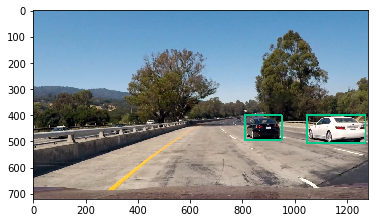

In [175]:
#example
bounding_boxes = [((810,400),(950,495)),((1045,400),(1270,505))]
plt.imshow(draw_boxes(mpimg.imread('test_images/test1.jpg'),bounding_boxes));

In [176]:
def get_hog_features(img, color_space='YUV'):
    """
    Takes in an RGB image and convert it to the color space specified by the parameter "color_space",
    Then extract HOG (histogram of oriented gradients) features.
    """
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'Lab':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
            
    hog = cv2.HOGDescriptor((64,64), (16,16), (8,8), (8,8), 9)
    return np.ravel(hog.compute(feature_image))

In [177]:
#example
hog = cv2.HOGDescriptor((64,64), (8,8), (8,8), (8,8), 9)
image = imread('test_images/test1.jpg')
hog.compute(image).shape

(7314624, 1)

In [178]:
#load vehicle and non-vehicle image sets
cars = glob.glob('dataset/vehicles/*/*.png')
notcar = glob.glob('dataset/non-vehicles/*/*.png')

In [179]:
print(len(cars))
print(len(notcar))

8792
8968


In [180]:
def extract_features(imgs, color_space='RGB', size = (64,64)):
    """
    Create HOG feature vector from list of images (image paths)
    
    params:
        imgs: list of image file paths (list)
        color_space: color_space that you want to convert to images to (str)
        size: dimensions to resize image (tuple)
        
    returns:
        list of hog transformed features
        
        
    """
    features = [] # hog features will be appended to this list
    hog = cv2.HOGDescriptor((64,64), (16,16), (8,8), (8,8), 9) #instantiate the hog transform
    
    for img in imgs: #iterate through all the images.
        img = imread(img)
        if size != (64,64):
            img = cv2.resize(img, size)
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'Lab':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img) 

        hog_features = np.ravel(hog.compute(feature_image)) #return a flattened feature array
        features.append(hog_features)

    return features

In [181]:
# build HOG feature vectors
car_features = extract_features(cars, color_space='YUV')
notcar_features = extract_features(notcar, color_space='YUV')

In [182]:
car_features[0].shape

(1764,)

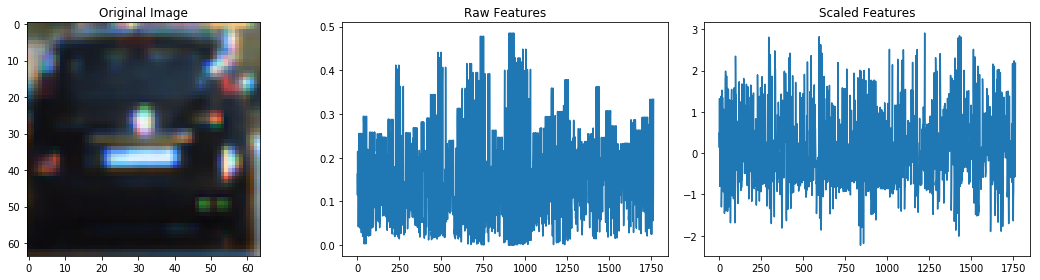

In [193]:
"""
Normalize the feature vectors (zero mean and unit variance)

"""

if len(car_features) > 0:
    # creates a feature vector of shape (n, 1764), where n is the number of images                     
    X = np.vstack((car_features, notcar_features)).astype(np.float64) 
    
    # fit a scaler on each column/feature of the dataset (this is used to normalize the features)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    
    ### plot an example of real image, raw features, and scaled features
    car_ind = np.random.randint(0, len(cars)) #generate random number to be used to grab the random image
    fig = plt.figure(figsize=(15,4))
    
    # plot the original image
    plt.subplot(131) #rows, columns, index
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    
    # plot the raw features
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    
    # plot the normalized features
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Scaled Features')
    
    fig.tight_layout()

In [184]:
# create outcome variable (1 for car, 0 for not car)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# shuffle and split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=1337)

In [216]:
"""
We train a number of classifers on the HOG feature vectors to see which works best.

After fitting each model, we measure the time it takes to do the prediction.  
The prediction speed is especially important because we want to be able to deploy this model in real time.

Assuming we need to run about 200 sliding windows per frame and need to run this at 60 frames per second.
We need the prediction time to be below:

1 / (200*60) = 0.00008333333 seconds in order for the model to run in real time.

For this project, we are preprocessing a video feed so we actually don't need real time, 
but its good to keep this in mind.

The SVM is the fastest to predict and takes approximately .000097 seconds to run on my laptop. 
This is followed by logistic regression (.00012 seconds), and the neural network (.0004).  
Although these numbers are higher than my minimum estimate, 
this could be okay since we would probably be using much faster hardware in a real self driving car.

In terms of performance, the neural network performs the best on the test set, with an accuracy of 99%

"""

def fit_model(model):
    model.fit(X_train, y_train)
    print("train accuracy: ", model.score(X_train, y_train))
    print("test accuracy: ", model.score(X_test, y_test))
    
    return model

def predict(model):
    prediction = model.predict(X_test[np.random.randint(0,len(X_test))].reshape(1, -1))
    
models = [LinearSVC(), LogisticRegression(), MLPClassifier()] #define models to be used
model_names = ['Support Vector Machines', 'Logistic Regression', 'Multilayered Perceptron']

for i, model in enumerate(models):
    
    print(model_names[i])
    
    model = fit_model(model)
    start=time.time()
    predict(model)
    finish=time.time()
    
    print(finish - start, " seconds to make the prediction")
    print('\n')

Support Vector Machines
train accuracy:  0.9998592342342343
test accuracy:  0.9527027027027027
0.00014591217041015625  seconds to make the prediction


Logistic Regression
train accuracy:  1.0
test accuracy:  0.9569256756756757
0.00018906593322753906  seconds to make the prediction


Multilayered Perceptron
train accuracy:  1.0
test accuracy:  0.9940878378378378
0.0004291534423828125  seconds to make the prediction




In [204]:
"""
Although it is the slowest to predict by a factor of about 4x compared to the other classifiers, 
the neural network / multi-layered perceptron has the highest test accuracy by a significant amount.
It is probably the best candidate to be used in the pipeline.
"""

neural_network = fit_model(MLPClassifier())

train accuracy:  1.0
test accuracy:  0.9940878378378378


['scaler.pkl']

In [ ]:
# save neural_network and scaler as pickle file
joblib.dump(neural_network, 'neural_network.pkl')
joblib.dump(X_scaler, 'scaler.pkl')

In [187]:
# load back in
neural_network = joblib.load('neural_network.pkl')
X_scaler = joblib.load('scaler.pkl')

In [274]:
"""
Next, we define the sliding window function
"""

def sliding_window(
      img
    , x_start_stop = [None, None]
    , y_start_stop = [None, None]
    , xy_window = (64, 64)
    , xy_overlap = (0.75, 0.75)
    ):
    
    """
    Given an image, calculates sliding windows
    
    params:
        img: image
        x_start_stop:  x coordinates of start/stop point (default to entire image size)
        y_start_stop:  y coordinates of start/stop point (default to entire image size)
        xy_window:  window size
        xy_overlap:  percentage overlap of sliding window
    
    returns:
        list of windows positions to be used in sliding window search
    
    """
    # If x or y start/stop coordinates are not defined, then default to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the size of each step (as a function of the window size and overlap percentage)
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) 
    ny_windows = np.int(yspan/ny_pix_per_step)
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # calculate window corners (bottom left and top right)
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx   = startx + xy_window[0]
            
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy   = starty + xy_window[1]
            
            window_list.append(((startx, starty), (endx, endy)))
            
    # Return the list of windows
    return window_list

In [302]:
def draw_bounding_boxes(image):
    """
    Annotate and visualize the sliding window detection on an image
    """
    
    image           = imread(image)
    detected        = []  # store windows in which cars are detected here
    window_size     = 80  # 320
    window_end_size = 160 # 720
    count           = 0   # count the number of detections
    
    while window_size < window_end_size: #720
        windows = sliding_window(image, x_start_stop=[None, None], y_start_stop=[400, 660], 
                            xy_window=(window_size, window_size), xy_overlap=(0.8, 0.8))  
        
        for window in windows:
            features = []
            current = cv2.resize((image[window[0][1]: window[1][1], window[0][0]: window[1][0]]), (64,64)) #resize the window to 64x64
            hog_features = get_hog_features(current,color_space='YUV') # get hog features
            hog_features = X_scaler.transform(hog_features.reshape(1, -1)) #normalize
            if current.shape[0] > 0:
                if neural_network.predict_proba(hog_features)[0][1] > .990:
                    detected.append(window)
            count += 1
        window_size += 16 # gradually increase the size of the window by increments of 16 pixels

    mask = np.zeros_like(image) # create a mask (all black)
    result = np.copy(image) # copy the image for drawing the boxes on
    
    # Draw all of the boxes on a mask image
    mask = draw_boxes(mask, detected, thick=-1)
    
    # Find the contours in the mask
    _, contours, _ = cv2.findContours(mask[:,:,2].astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    for countour in contours:
        #draw bounding boxes in the image
        x,y,w,h = cv2.boundingRect(countour) #returns bottom left corner (x,y), and width (w) and height (h)
        cv2.rectangle(result, (x, y), (x + w, y + h), (0,255,30), 4)
        
        #calculate the centroid of the countour
        M = cv2.moments(countour)
        c = (int(M['m10'] / M['m00']), int(M['m01'] / M['m00']))
        cv2.circle(result, c, 10, (0, 0, 255), -1)
        
    f, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(15,15))
    f.tight_layout()
    
    ax1.axis('off')
    ax1.set_title('Image')
    ax1.imshow(image)
    
    ax2.axis('off')
    ax2.set_title('Car Detections')
    ax2.imshow(mask, cmap='hot')
    
    ax3.axis('off')
    ax3.set_title('Image with Bounding Box')
    ax3.imshow(result)

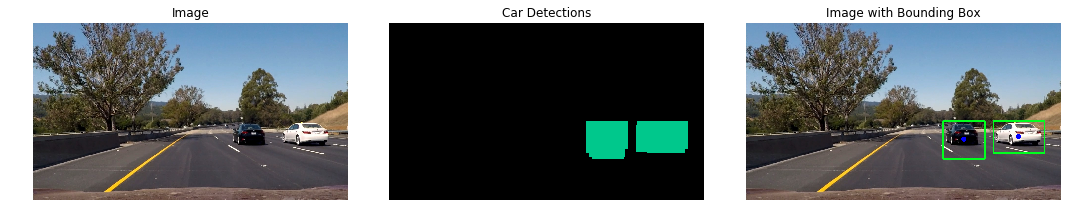

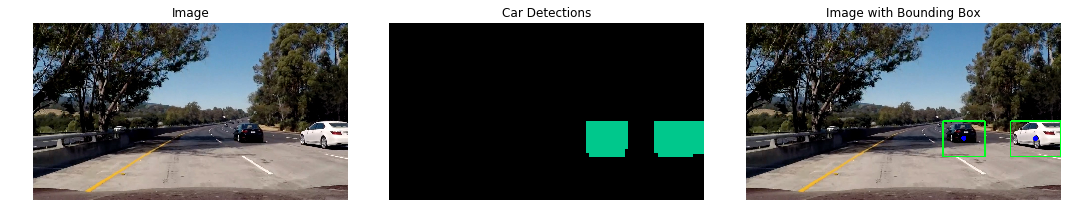

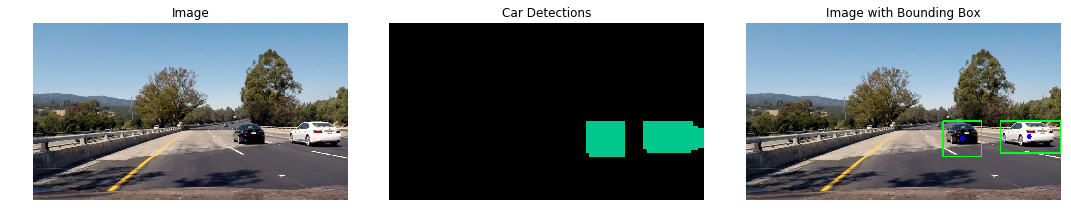

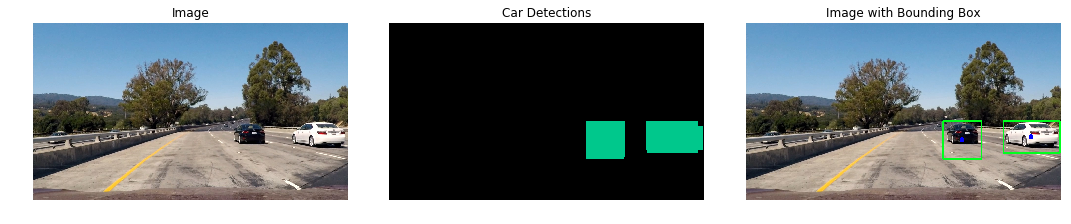

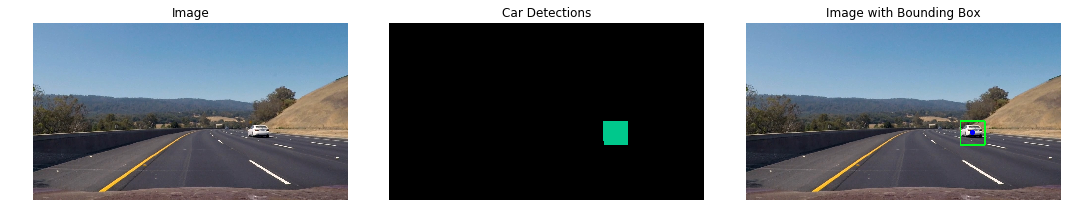

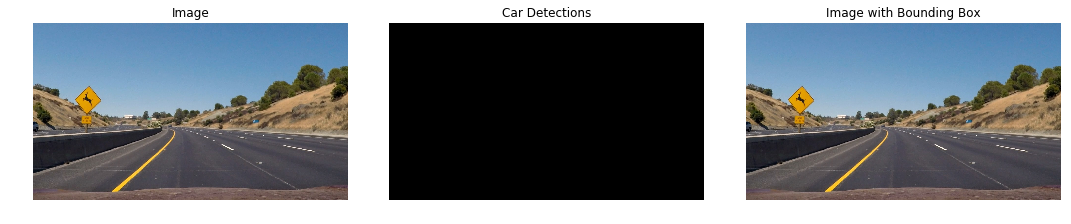

In [303]:
for image in glob.glob('test_images/*.jpg'):
    draw_bounding_boxes(image);

In [312]:
"""
We use a deque to store bounding boxes from the last 12 frames of the video as it is being processed.
The final list of bounding rectanges will be generated from the last 12 frames of the video instead of just using one frame.  
Using data from multiple frames should make the model more robust.
"""

from collections import deque
class boxes:
    def __init__(self):
        self.count = 0
        self.detections = deque(maxlen=12)

In [310]:
"""
Process the video using all the techniques described above
"""

def process_video(image):
    detected        = []  # store windows in which cars are detected here
    window_size     = 80  # 320
    window_end_size = 160 # 720
    count           = 0   # count the number of detections
    
    while window_size < window_end_size:
        windows = sliding_window(image, x_start_stop=[640, None], y_start_stop=[400, 660], 
                            xy_window=(window_size, window_size), xy_overlap=(0.8, 0.8))  
        for window in windows:
            features = []
            current = cv2.resize((image[window[0][1]: window[1][1], window[0][0]: window[1][0]]),(64,64))
            hog_features = get_hog_features(current, color_space='YUV')
            
            scaled_features = X_scaler.transform(hog_features.reshape(1, -1))
            if current.shape[0] > 0:
                if neural_network.predict_proba(scaled_features.reshape(1,-1))[0][1] > .99:
                    detected.append(window)
            count += 1
        window_size += 16
        
    result = np.copy(image).astype('uint8')
    mask = np.zeros_like(image)
    mask = draw_boxes(mask, detected, thick=-1)
    
    rect_list = [] # used for storing all the rectangles
    
    _, contours, _ = cv2.findContours(mask[:,:,2].astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        rect_list.append([x,y,x+w,y+h])  # add bounding rectanges from the single video frame to the rectangle list
        
    Boxes.detections.append(rect_list) # add rectanges to the queue in the Boxes class
    all_boxes = []
    combined = np.ravel(np.array(Boxes.detections)) # merge all the rectangles into a single list
    
    for i in range(len(combined)):
        all_boxes.extend(np.ravel(combined[i]))  # add all the boxes into a single list
    
    # group rectangles back into groups of 4
    new_boxes = [] #array for storing new boxes?
    i = 0
    while i <= len(all_boxes)-3:
        new_boxes.append(all_boxes[i:i + 4]) 
        i += 4
    
    # group overlapping rectangles together into a single rectangle
    # see https://docs.opencv.org/2.4/modules/objdetect/doc/cascade_classification.html
    rects, w = cv2.groupRectangles(np.array(new_boxes).tolist(), 10,.1) 
    
    # finally, draw all rectangles onto the image
    for rect in rects:
        cv2.rectangle(result, (rect[0], rect[1]), (rect[2],rect[3]), (0,255,0), 5)
    Boxes.count += 1
    
    return result

In [313]:
help(cv2.groupRectangles)

Help on built-in function groupRectangles:

groupRectangles(...)
    groupRectangles(rectList, groupThreshold[, eps]) -> rectList, weights



In [311]:
Boxes = boxes()
output = 'result2.mp4'
clip1 = VideoFileClip('project_video.mp4').subclip(5,) # The first 5 seconds doesn't have any cars...
clip = clip1.fl_image(process_video)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video result2.mp4
[MoviePy] Writing video result2.mp4



100%|█████████▉| 1135/1136 [16:10<00:00,  1.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result2.mp4 

CPU times: user 28min 47s, sys: 2min 14s, total: 31min 2s
Wall time: 16min 11s


In [ ]:
"""
Possible areas for further improvement
-  Use a heatmap approach to make model more robust 
(possibly reduce false positives, and make bounding box more tight around the car)
- augment the training set size
- multiple object detection (pedestrians, cars, traffic lights)

"""